In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math
from typing import Tuple

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
from PIL import Image
import IPython.display as disp

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path

pred_threshold       = params.pred_threshold_tick
trailing_stop_pred   = params.trailing_stop_pred_tick

Model selected: dfs_training/AAPL_0.1818.pth 

{'ATT_DROPOUT': 0.1,
 'ATT_HEADS': 16,
 'CLIPNORM': 1.0,
 'CLS_LOSS_WEIGHT': 0.5,
 'DROPOUT_LONG': 0.1,
 'DROPOUT_SHORT': 0.1,
 'EARLY_STOP_PATIENCE': 15,
 'ETA_MIN': 1e-05,
 'HUBER_BETA': 0.5,
 'INITIAL_LR': 0.001,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 5,
 'MAX_EPOCHS': 90,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 128,
 'TRAIN_BATCH': 16,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 90,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 1e-05}


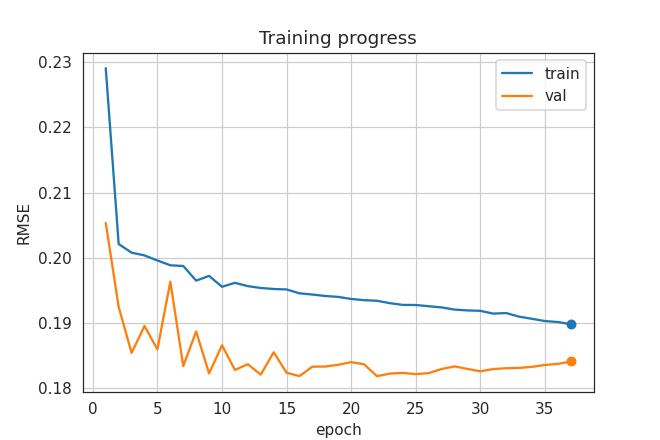

DualMemoryLSTM(
  (conv): Conv1d(15, 15, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(15, 64, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.1, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.1, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
)

In [3]:
model_path = min(
    save_path.glob(f"{ticker}_*.pth"),
    key=lambda p: float(p.stem.split("_")[-1])
)
print('Model selected:', model_path,'\n')

# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [4]:
df_pred = pd.read_csv(params.pred_csv, index_col=0, parse_dates=True)
df_pred

open      high       low     close      volume  \
2022-03-29 13:30:00 -0.060241 -0.114663 -0.050567 -0.076417   -0.433215   
2022-03-29 13:31:00 -0.067126 -0.114663 -0.021316 -0.090330   -0.489096   
2022-03-29 13:32:00 -0.108434 -0.128217 -0.071773 -0.083374   -0.459415   
2022-03-29 13:33:00 -0.087780 -0.121440 -0.057879 -0.118157   -0.468064   
2022-03-29 13:34:00 -0.129088 -0.128217 -0.109068 -0.083374   -0.451175   
...                       ...       ...       ...       ...         ...   
2025-06-18 20:56:00  0.475806  0.704918  0.500000  0.705997    5.467381   
2025-06-18 20:57:00  0.685484  0.836066  0.387097  0.478780    6.628840   
2025-06-18 20:58:00  0.467742  0.508197  0.500000  0.470665    7.630343   
2025-06-18 20:59:00  0.475806  0.524590 -0.129032 -0.227217   31.658646   
2025-06-18 21:00:00  0.314516  0.360656 -0.387097  0.259677  241.291957   

                       atr_14      ma_5     ma_20   ma_diff  macd_12_26  ...  \
2022-03-29 13:30:00  0.318075 -0.050723 -0.352893  1.878937    1.445582  ...   
2022-03-29 13:31:00  0.163168 -0.061551 -0.333667  1.658208    1.424596  ...   
2022-03-29 13:32:00  0.120827 -0.065611 -0.314079  1.486818    1.396960  ...   
2022-03-29 13:33:00  0.172463 -0.072379 -0.290137  1.263492    1.315588  ...   
2022-03-29 13:34:00  0.038210 -0.079146 -0.266196  1.040166    1.274443  ...   
...                       ...       ...       ...       ...         ...  ...   
2025-06-18 20:56:00  2.024482  0.367023 -0.130453  2.191746    1.957857  ...   
2025-06-18 20:57:00  2.207440  0.460866 -0.093452  2.466615    1.999189  ...   
2025-06-18 20:58:00  2.216153  0.497086 -0.060109  2.478653    2.004989  ...   
2025-06-18 20:59:00  2.487280  0.408182 -0.062549  2.057321    1.614144  ...   
2025-06-18 21:00:00  2.861997  0.358792 -0.032866  1.670098    1.550358  ...   

                     stoch_d_3  in_trading   hour  day_of_week  month  \
2022-03-29 13:30:00   1.310914           0  0.493        0.808  0.979   
2022-03-29 13:31:00   1.288726           0  0.493        0.808  0.979   
2022-03-29 13:32:00   1.208076           0  0.493        0.808  0.979   
2022-03-29 13:33:00   1.098103           0  0.493        0.808  0.979   
2022-03-29 13:34:00   1.056336           0  0.493        0.808  0.979   
...                        ...         ...    ...          ...    ...   
2025-06-18 20:56:00   0.342752           1 -0.939        0.039  0.146   
2025-06-18 20:57:00   0.415204           1 -0.939        0.039  0.146   
2025-06-18 20:58:00   0.370103           1 -0.939        0.039  0.146   
2025-06-18 20:59:00  -0.192907           1 -0.939        0.039  0.146   
2025-06-18 21:00:00  -0.332445           0 -0.960        0.039  0.146   

                          bid       ask    signal  pred_signal  pred_action  
2022-03-29 13:30:00  176.7573  177.0227  0.004176     0.260638            0  
2022-03-29 13:31:00  176.7373  177.0027  0.004709     0.234837            0  
2022-03-29 13:32:00  176.7473  177.0127  0.005036     0.224877            0  
2022-03-29 13:33:00  176.6974  176.9626  0.011348     0.232669            0  
2022-03-29 13:34:00  176.7473  177.0127  0.005966     0.233658            0  
...                       ...       ...       ...          ...          ...  
2025-06-18 20:56:00  196.6674  196.9626  0.000000     0.117633            0  
2025-06-18 20:57:00  196.5275  196.8225  0.000000     0.122878            0  
2025-06-18 20:58:00  196.5225  196.8175  0.000000     0.116394            0  
2025-06-18 20:59:00  196.0928  196.3872  0.043551     0.111566            0  
2025-06-18 21:00:00  196.3926  196.6874  0.000000     0.120234            0  

[364691 rows x 31 columns]

In [5]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_pred[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_pred['signal'].corr(df_pred['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

count      mean       std       min       25%       50%  \
signal       364691.0  0.178958  0.201838  0.000000  0.035972  0.114968   
pred_signal  364691.0  0.167700  0.122215 -0.004547  0.090721  0.138319   

                  75%       max     range  pearson_r_with_other  
signal       0.246303  1.000000  1.000000              0.427759  
pred_signal  0.204618  1.079763  1.084311              0.427759

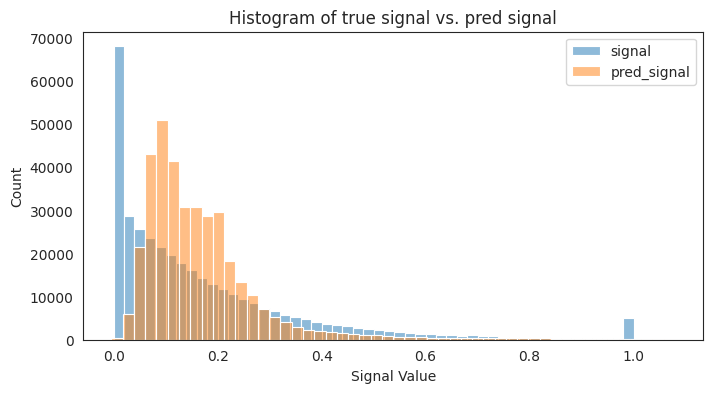

In [6]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_pred['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_pred['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

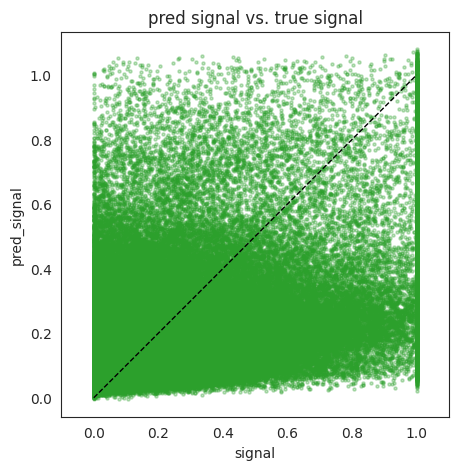

In [7]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_pred['signal'], df_pred['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

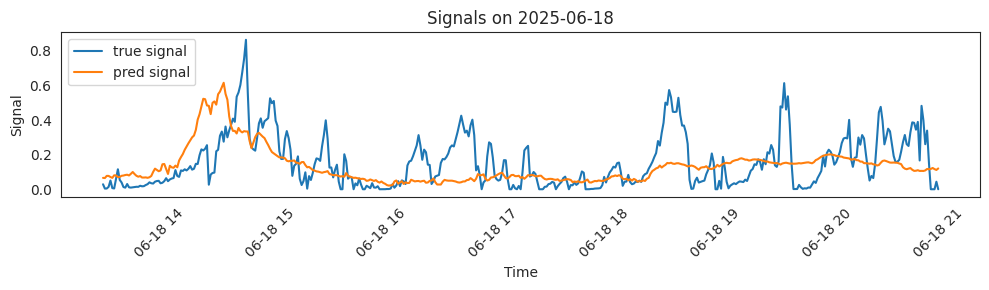

In [8]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the signal on a given day.

# pick a single day or time span
day = df_pred.index.normalize().unique()[-1]
mask = df_pred.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_pred.index[mask], df_pred.loc[mask,'signal'], label='true signal')
plt.plot(df_pred.index[mask], df_pred.loc[mask,'pred_signal'],   label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

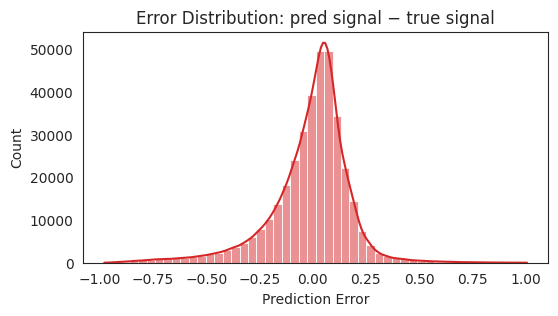

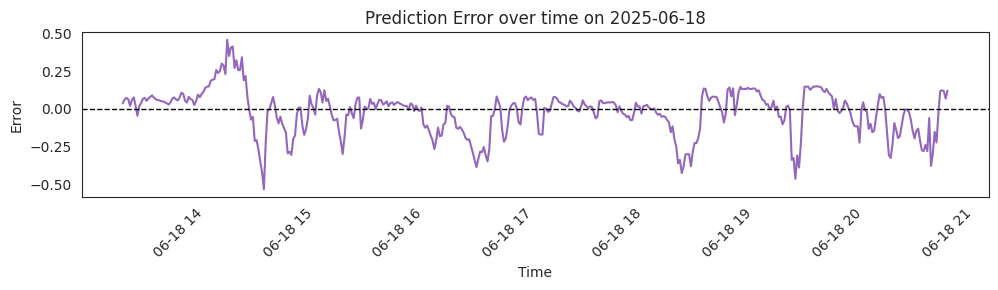

In [9]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_pred['error'] = df_pred['pred_signal'] - df_pred['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_pred['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_pred.index[mask], df_pred.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# If running generate_trade_actions on a multi-day block, the in_trade flag won’t reset at midnight. Splitting by day below avoids that.

# how many unique days we’ll process
groups = list(df_pred.groupby(df_pred.index.normalize()))
n_days = len(groups)

sim_results = {}

for day, df_day in tqdm(groups, total=n_days, desc="Generate+Simulate"):
    # 1) Generate trade actions for this day
    df_actions = trades.generate_trade_actions(
        df=df_day,
        col_signal="pred_signal",
        col_action="pred_action",
        buy_threshold=pred_threshold,
        trailing_stop_pct=trailing_stop_pred,
        sess_start=params.sess_start
    )

    # 2) Simulate trading on this single‐day mini‐dict
    single_result = trades.simulate_trading(
        results_by_day_sign={day: (df_actions, [])},
        col_action="pred_action",
        sess_start=params.sess_start,
        sess_end=params.sess_end,
        ticker=ticker
    )

    # 3) Collect the output
    # single_result is { day: (df_sim, trades, stats) }
    sim_results.update(single_result)



Generate+Simulate:   0%|          | 0/809 [00:00<?, ?it/s]


Plotting days in 2024-06:


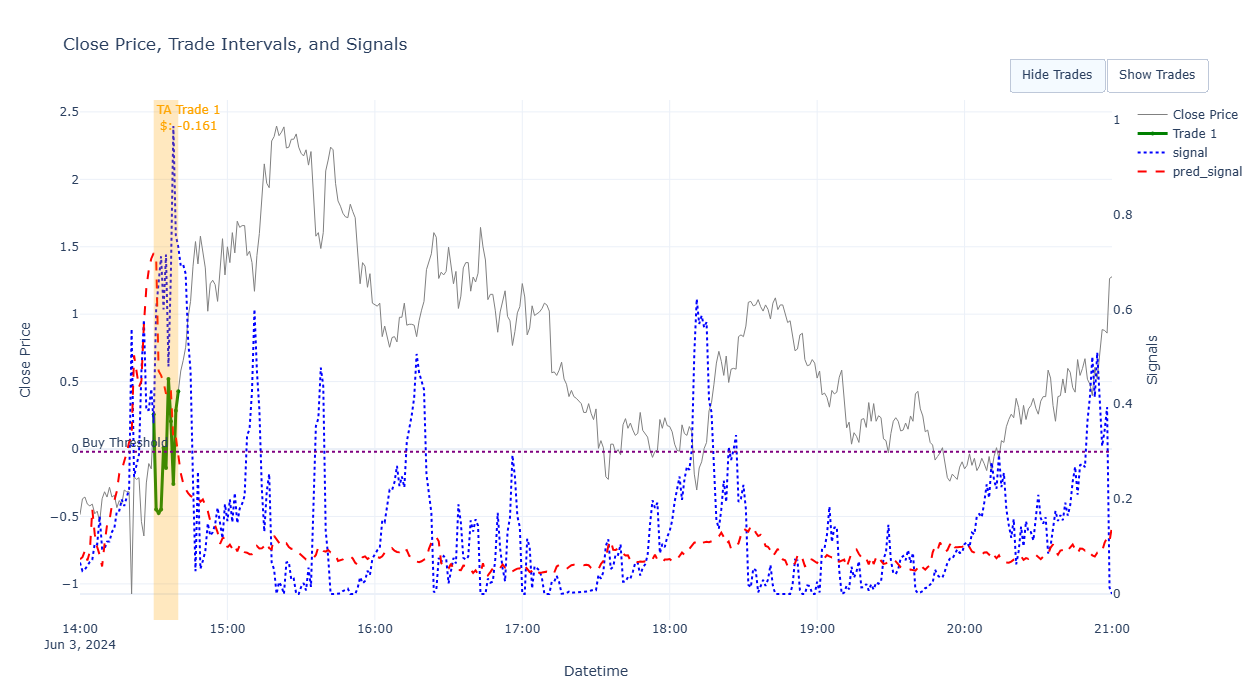


=== Performance for 2024-06-03 00:00:00 ===
Buy & Hold Return ($): 0.489
Strategy Return ($): -0.16
Trades Returns ($): [-0.161]


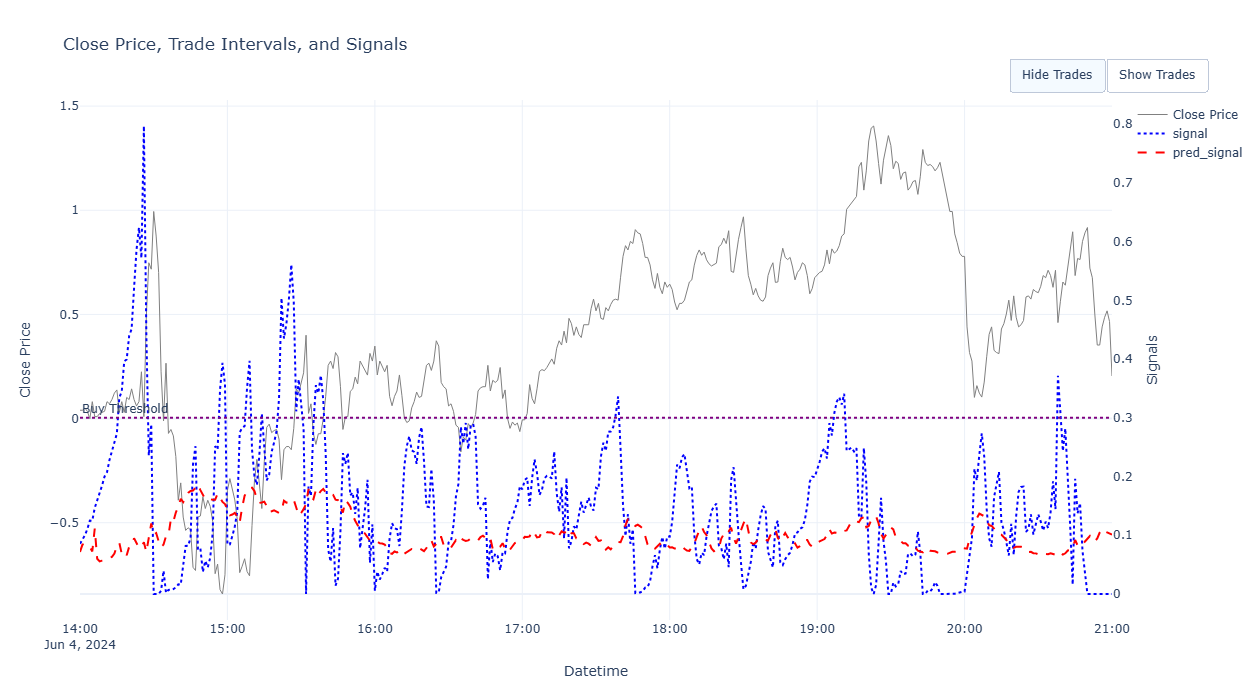


=== Performance for 2024-06-04 00:00:00 ===
Buy & Hold Return ($): -1.062
Strategy Return ($): 0.0
Trades Returns ($): []


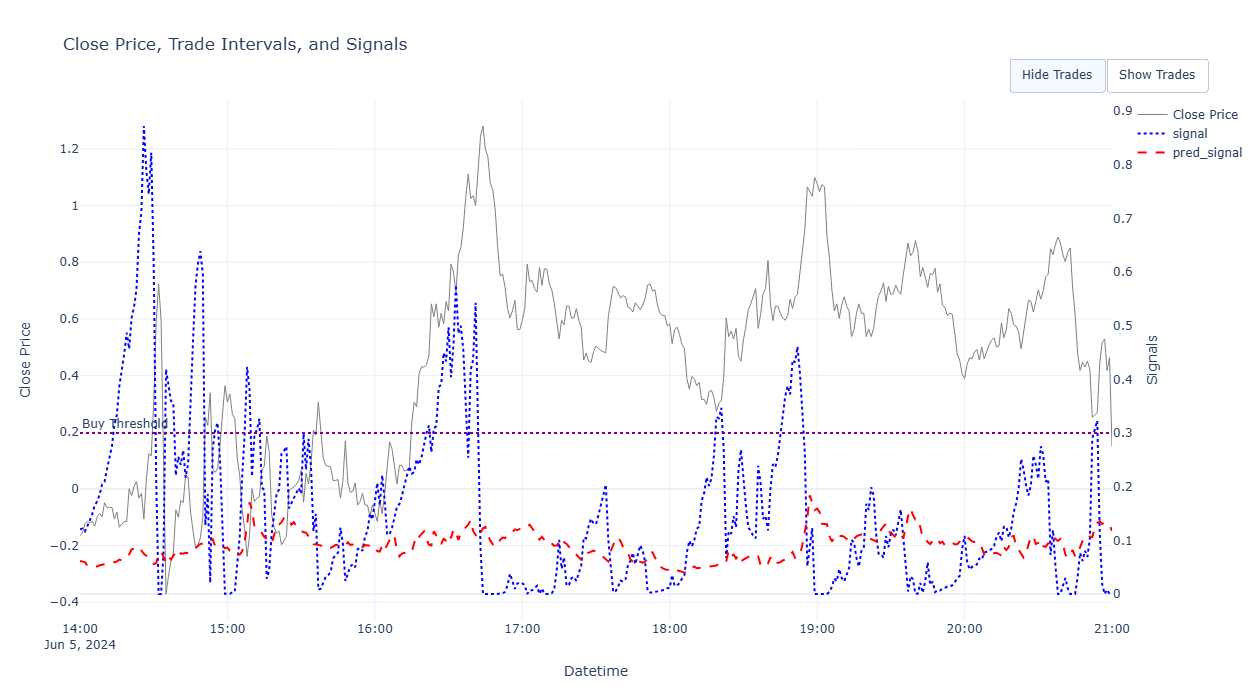


=== Performance for 2024-06-05 00:00:00 ===
Buy & Hold Return ($): -0.484
Strategy Return ($): 0.0
Trades Returns ($): []


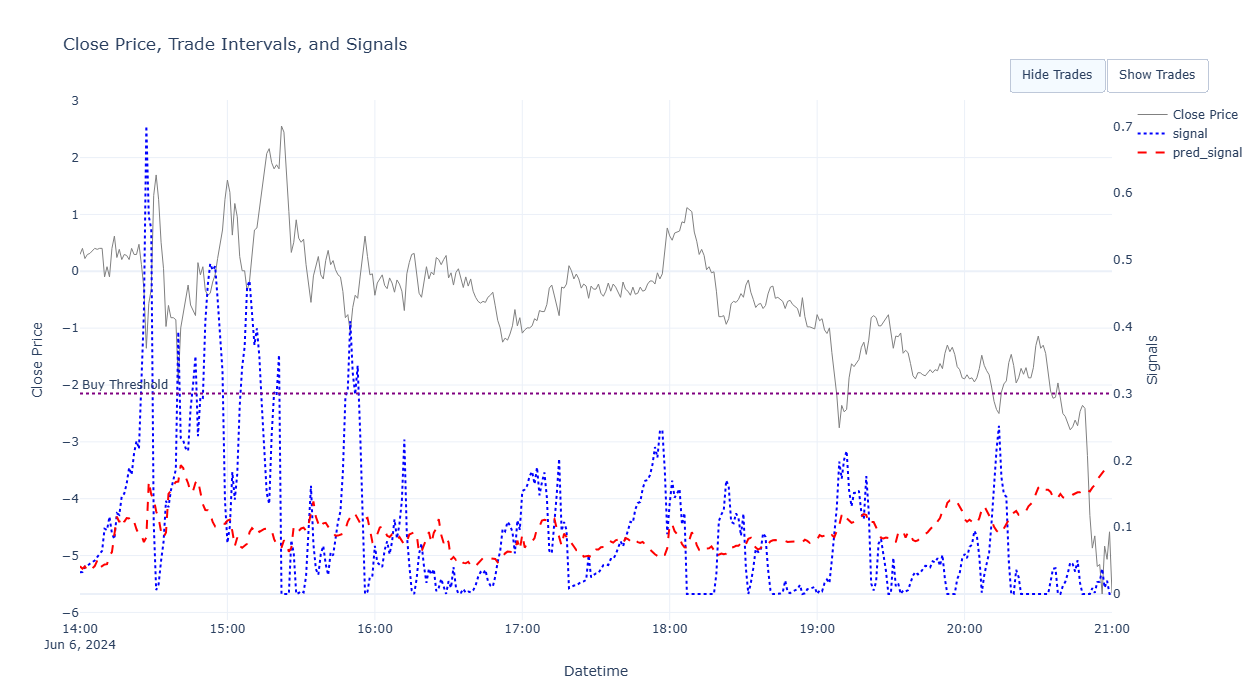


=== Performance for 2024-06-06 00:00:00 ===
Buy & Hold Return ($): -2.243
Strategy Return ($): 0.0
Trades Returns ($): []


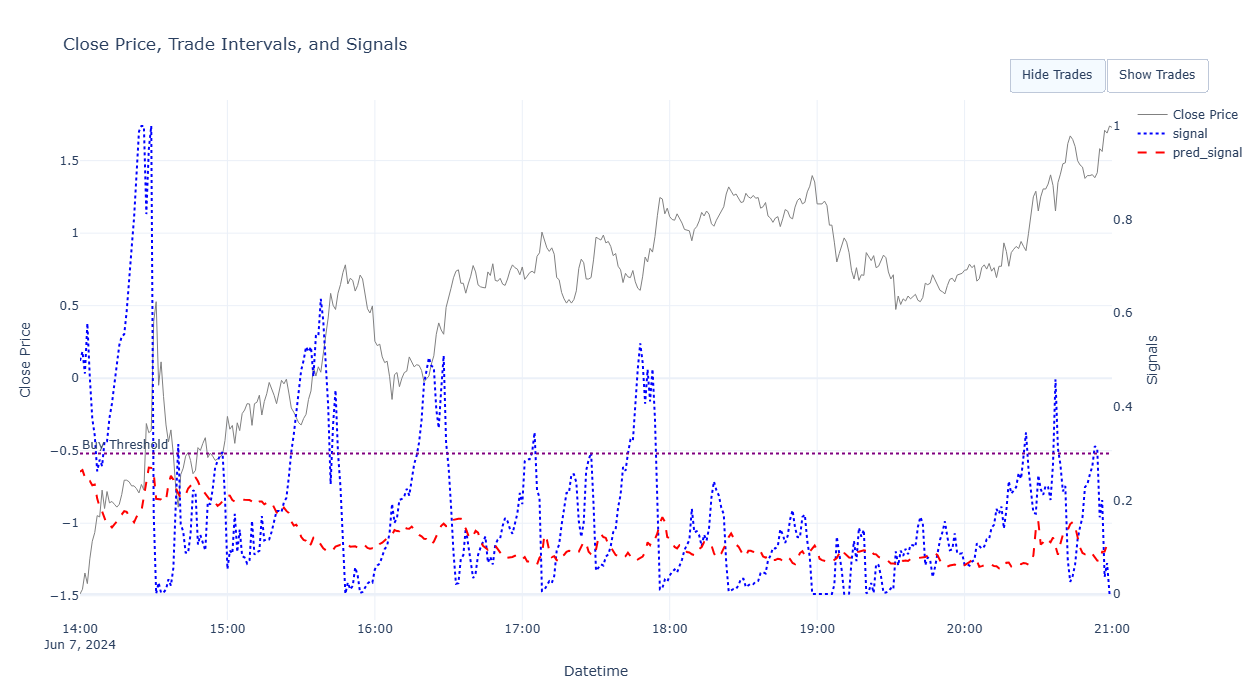


=== Performance for 2024-06-07 00:00:00 ===
Buy & Hold Return ($): 1.076
Strategy Return ($): 0.0
Trades Returns ($): []


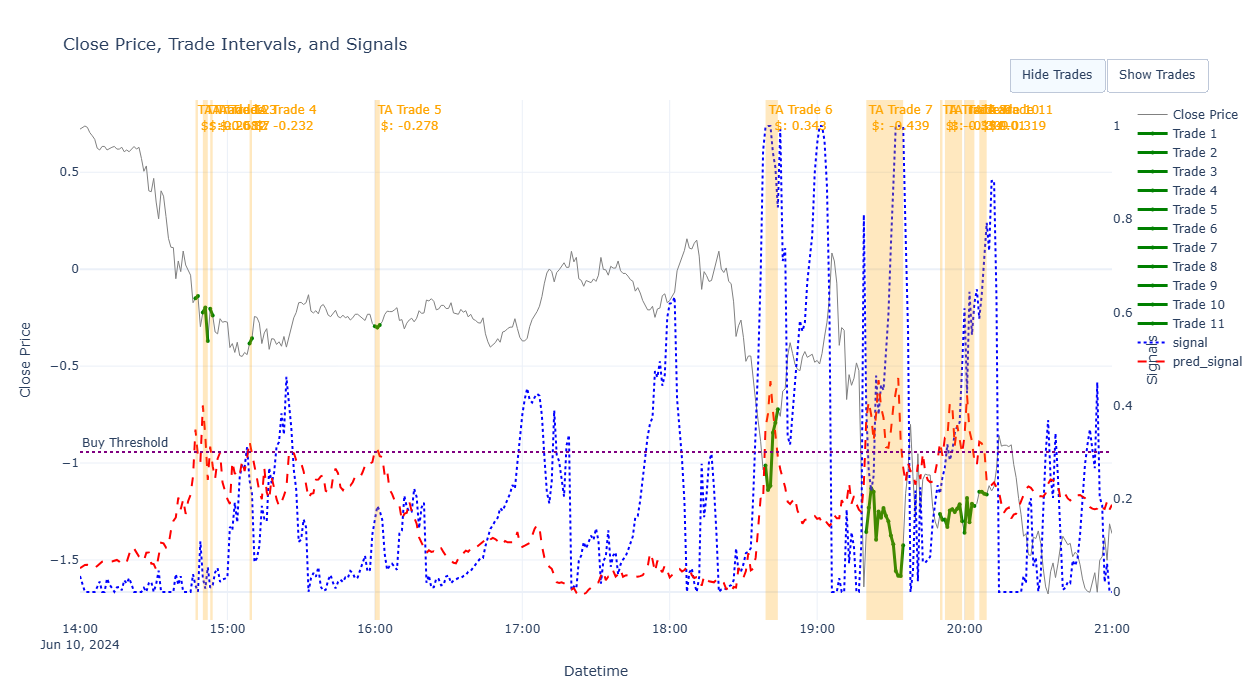


=== Performance for 2024-06-10 00:00:00 ===
Buy & Hold Return ($): -4.293
Strategy Return ($): -2.833
Trades Returns ($): [-0.268, -0.612, -0.37, -0.232, -0.278, 0.343, -0.439, -0.354, -0.309, 0.01, -0.319]


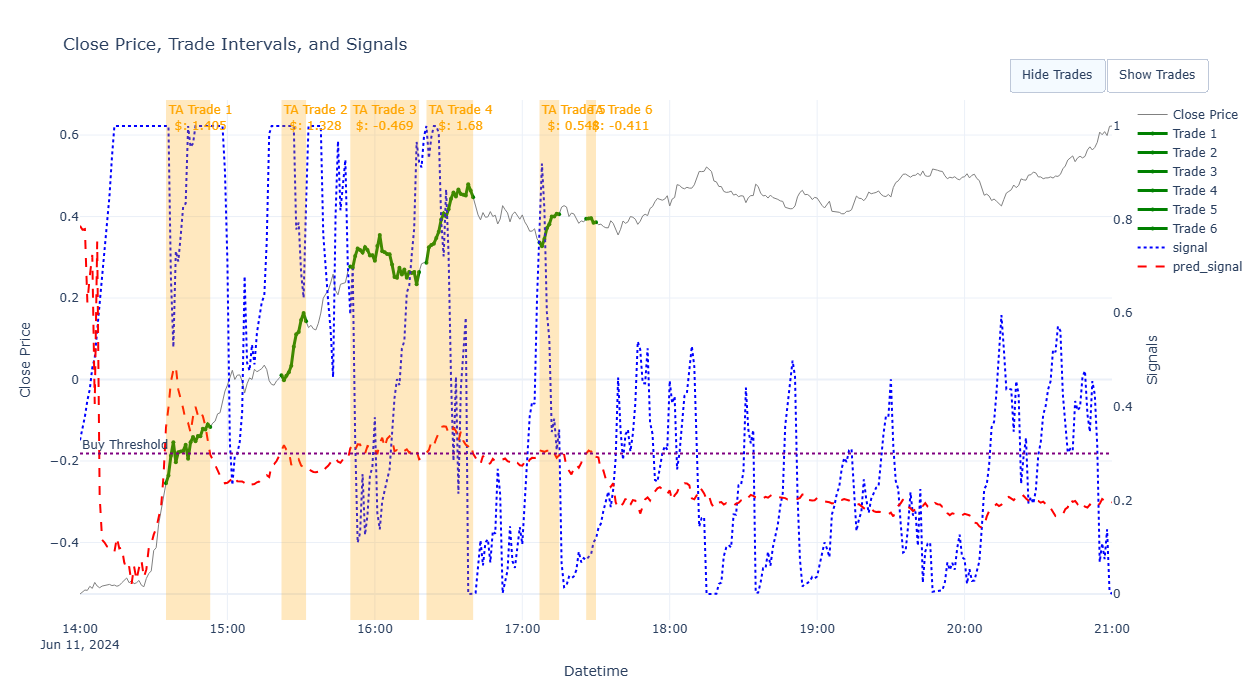


=== Performance for 2024-06-11 00:00:00 ===
Buy & Hold Return ($): 12.544
Strategy Return ($): 4.082
Trades Returns ($): [1.405, 1.328, -0.469, 1.68, 0.548, -0.411]


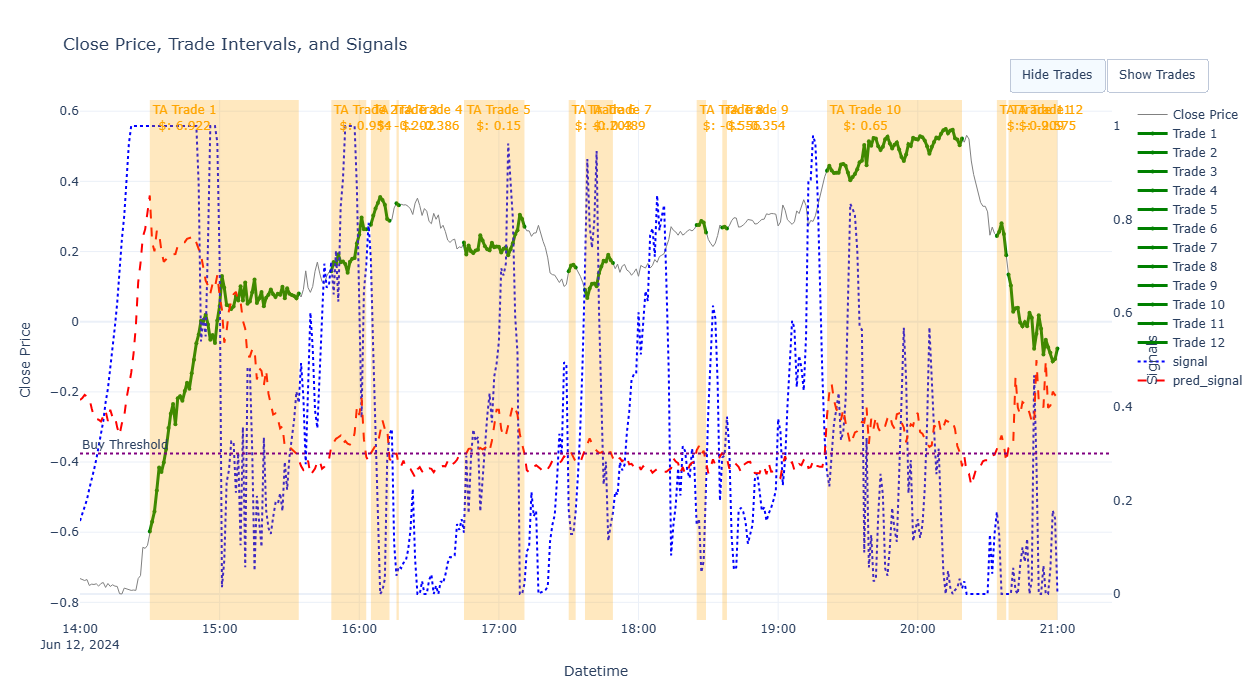


=== Performance for 2024-06-12 00:00:00 ===
Buy & Hold Return ($): 5.249
Strategy Return ($): 3.981
Trades Returns ($): [6.922, 0.954, -0.202, -0.386, 0.15, -0.203, 0.489, -0.556, -0.354, 0.65, -0.909, -2.575]


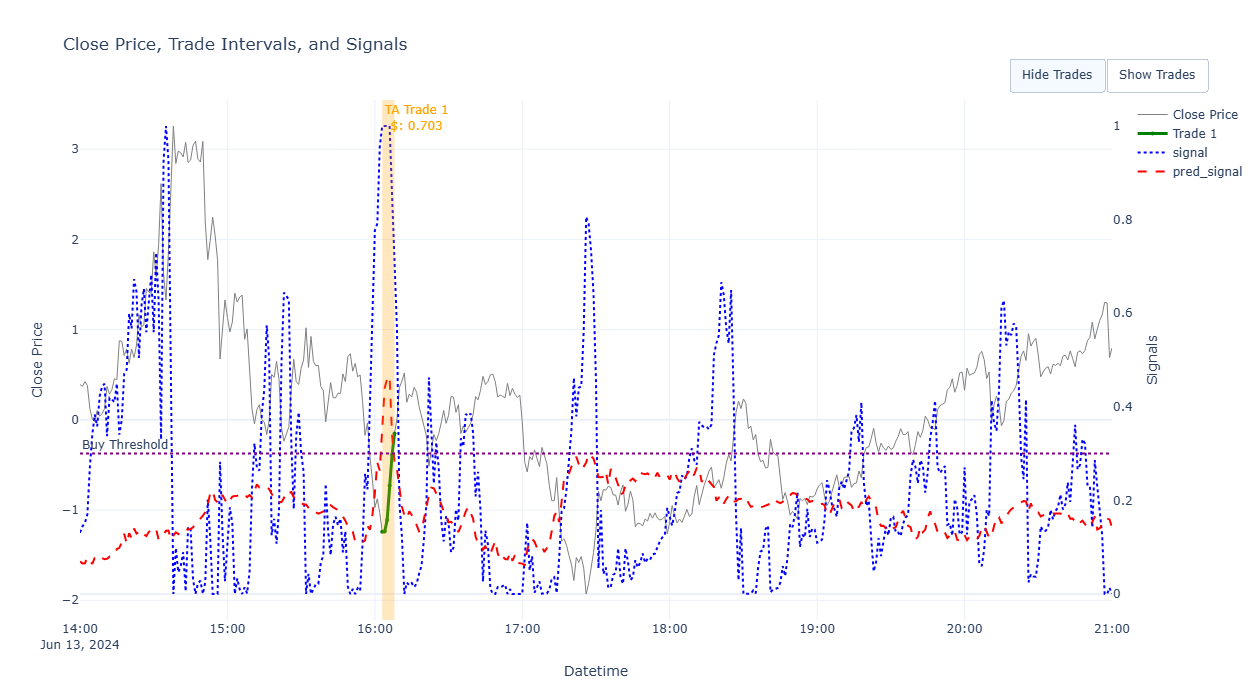


=== Performance for 2024-06-13 00:00:00 ===
Buy & Hold Return ($): -1.322
Strategy Return ($): 0.704
Trades Returns ($): [0.703]


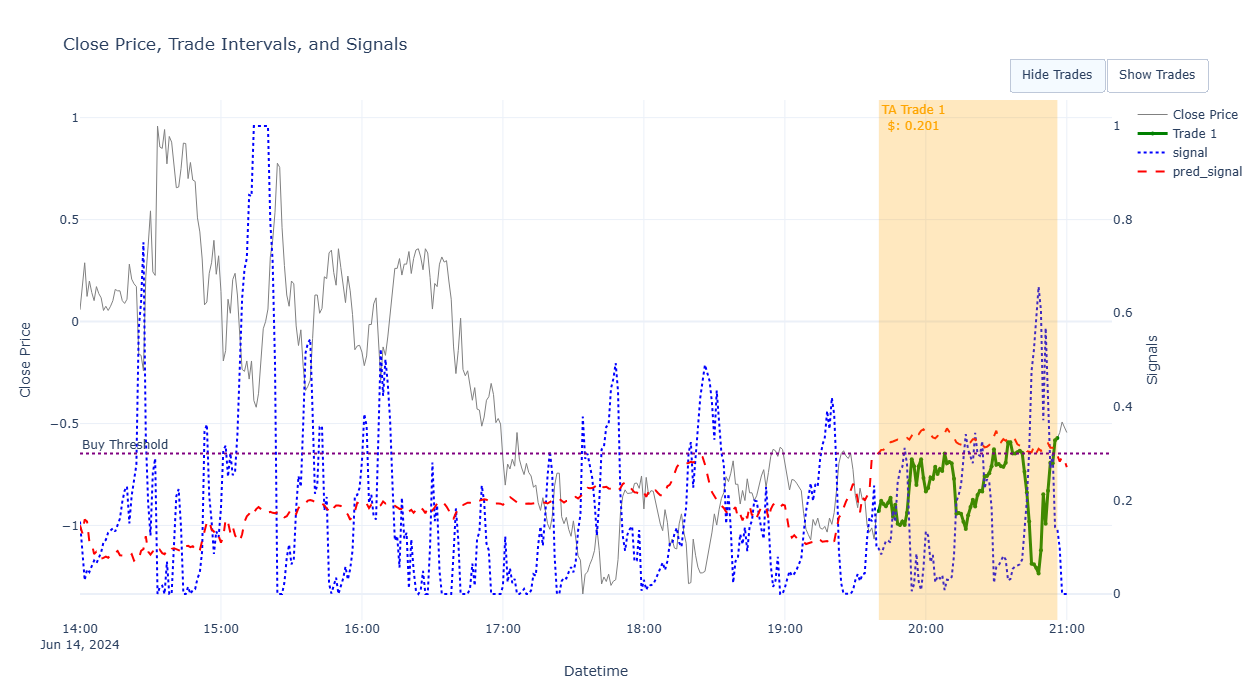


=== Performance for 2024-06-14 00:00:00 ===
Buy & Hold Return ($): -1.9
Strategy Return ($): 0.202
Trades Returns ($): [0.201]


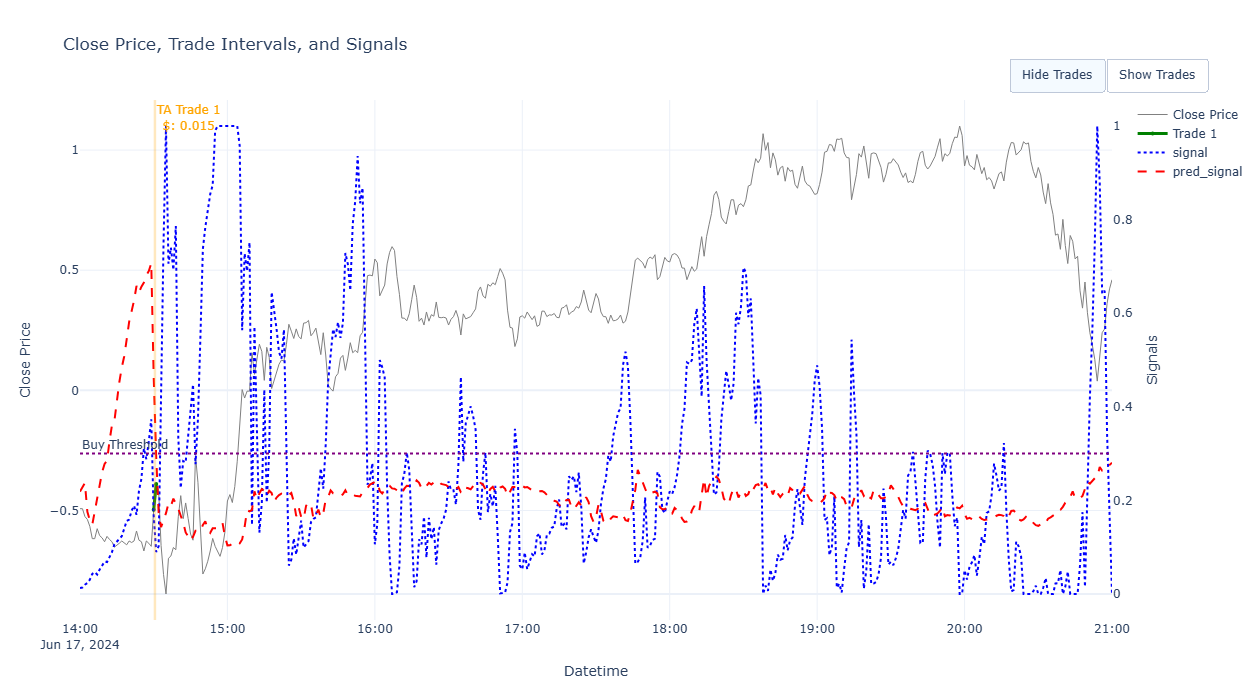


=== Performance for 2024-06-17 00:00:00 ===
Buy & Hold Return ($): 2.672
Strategy Return ($): 0.014
Trades Returns ($): [0.015]


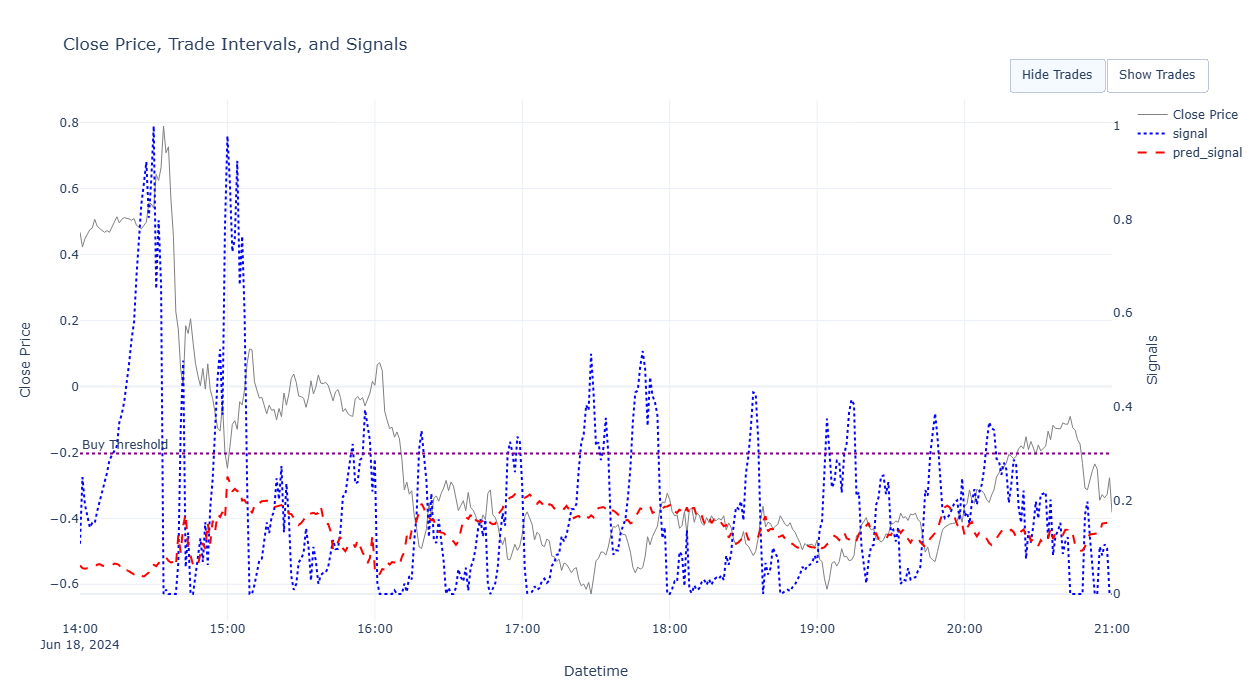


=== Performance for 2024-06-18 00:00:00 ===
Buy & Hold Return ($): -3.844
Strategy Return ($): 0.0
Trades Returns ($): []


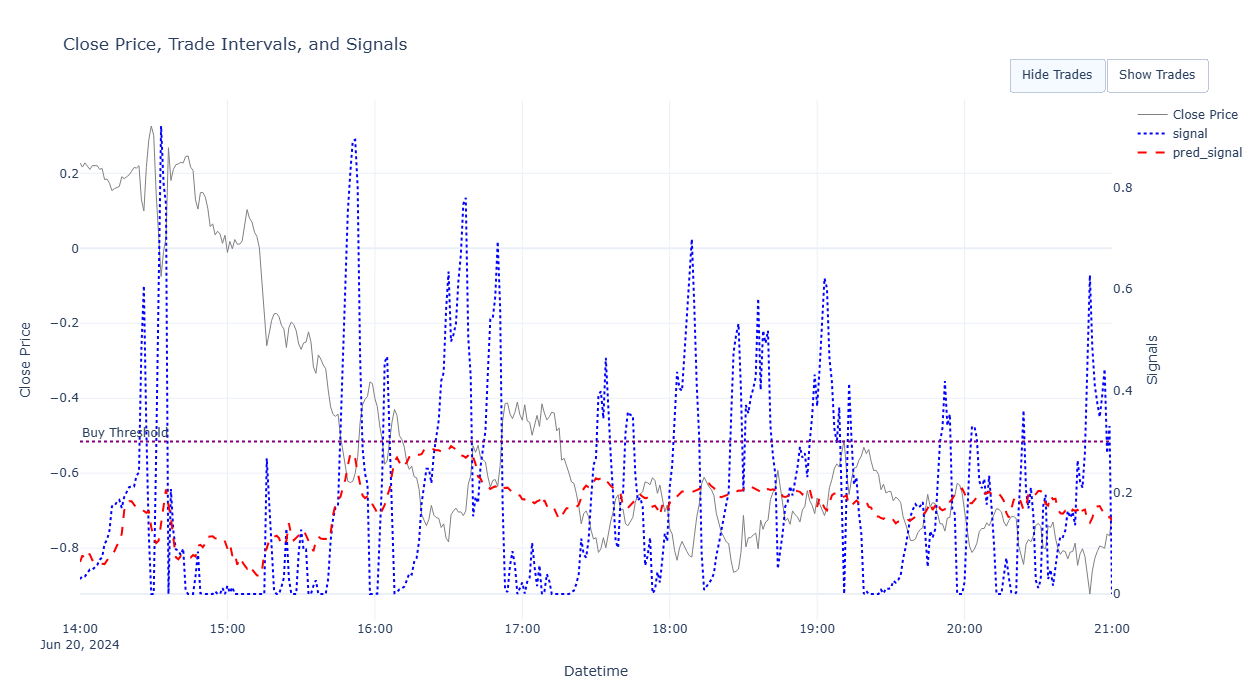


=== Performance for 2024-06-20 00:00:00 ===
Buy & Hold Return ($): -4.428
Strategy Return ($): 0.0
Trades Returns ($): []


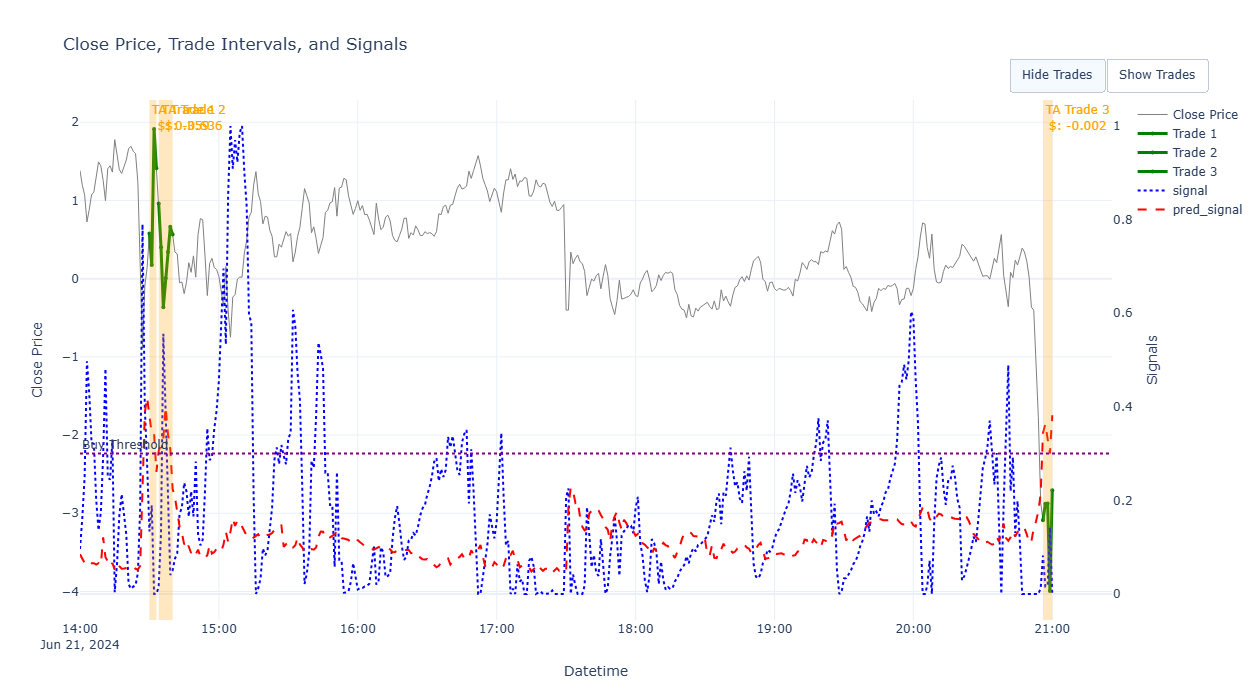


=== Performance for 2024-06-21 00:00:00 ===
Buy & Hold Return ($): -2.964
Strategy Return ($): -0.279
Trades Returns ($): [0.359, -0.636, -0.002]


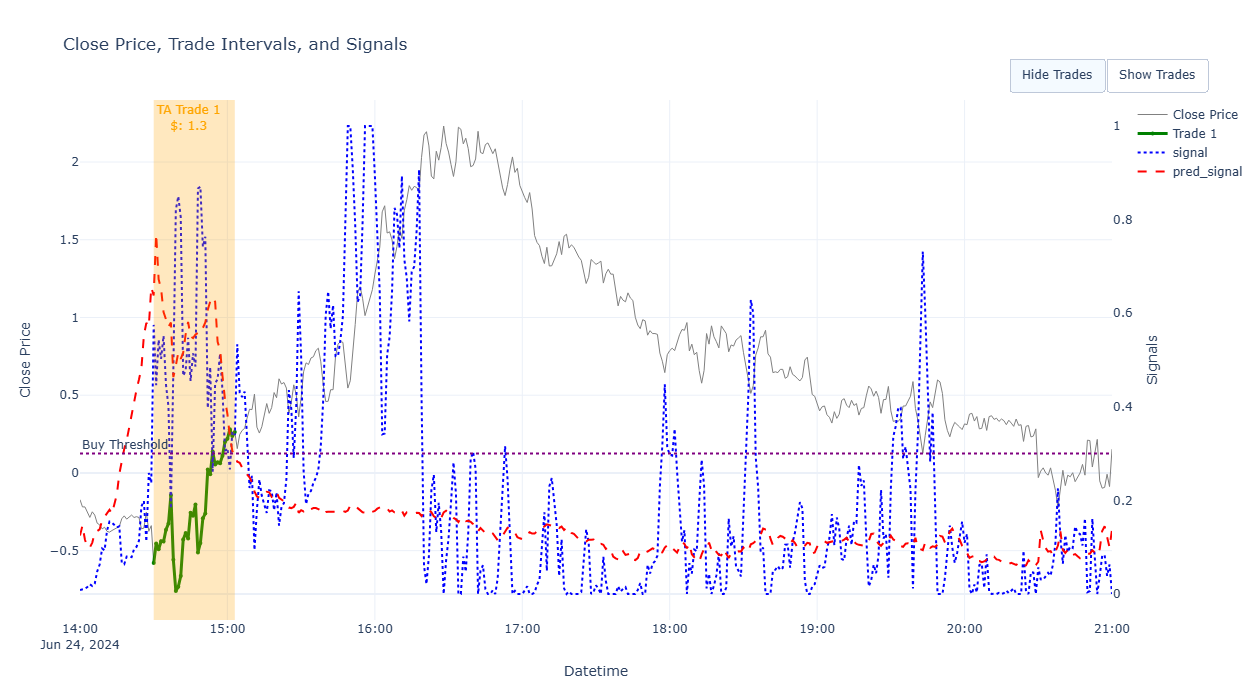


=== Performance for 2024-06-24 00:00:00 ===
Buy & Hold Return ($): 1.088
Strategy Return ($): 1.3
Trades Returns ($): [1.3]


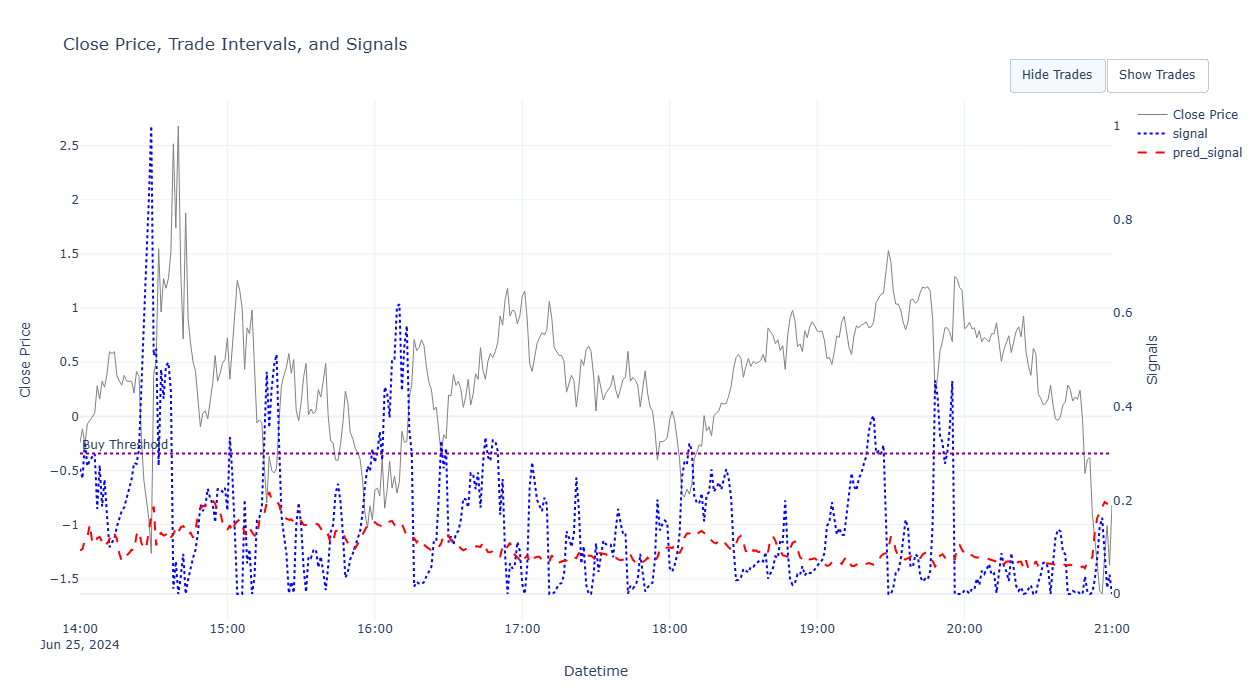


=== Performance for 2024-06-25 00:00:00 ===
Buy & Hold Return ($): -0.975
Strategy Return ($): 0.0
Trades Returns ($): []


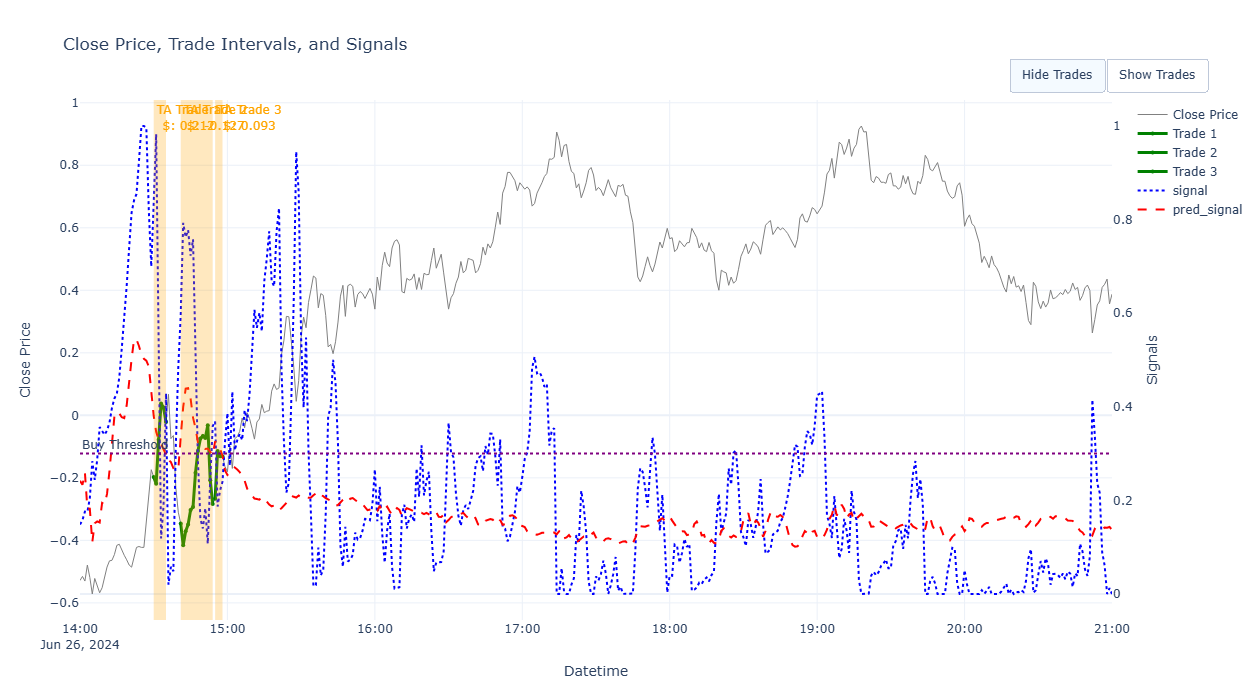


=== Performance for 2024-06-26 00:00:00 ===
Buy & Hold Return ($): 1.446
Strategy Return ($): 0.179
Trades Returns ($): [0.212, -0.127, 0.093]


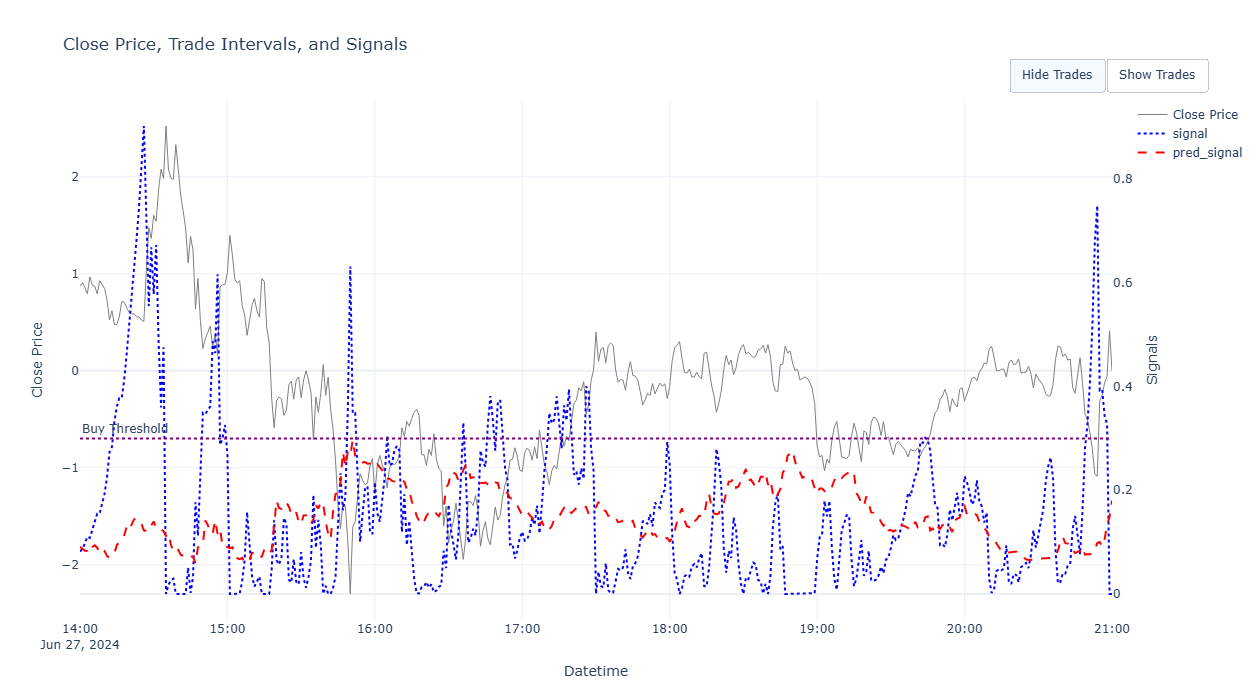


=== Performance for 2024-06-27 00:00:00 ===
Buy & Hold Return ($): -1.331
Strategy Return ($): 0.0
Trades Returns ($): []


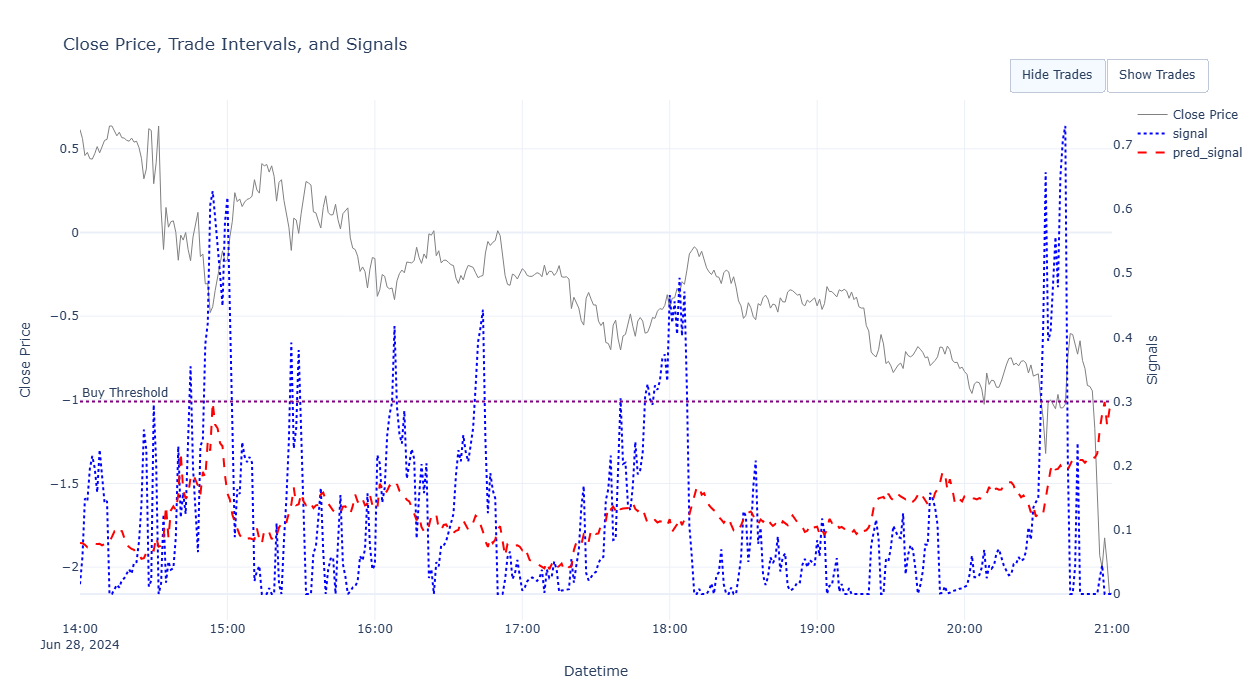


=== Performance for 2024-06-28 00:00:00 ===
Buy & Hold Return ($): -4.894
Strategy Return ($): 0.0
Trades Returns ($): []

Overall Summary (2024-06-03 = 193.4650 → 2024-06-28 = 210.4620)

One-time buy&hold gain: 16.997
Buy & Hold – each day ($): -5.176
Strategy Return ($): 7.190
Trades Count: 40
Strategy return per trade: 0.180
Num. trading days: 19
Strategy return per trading day: 0.378


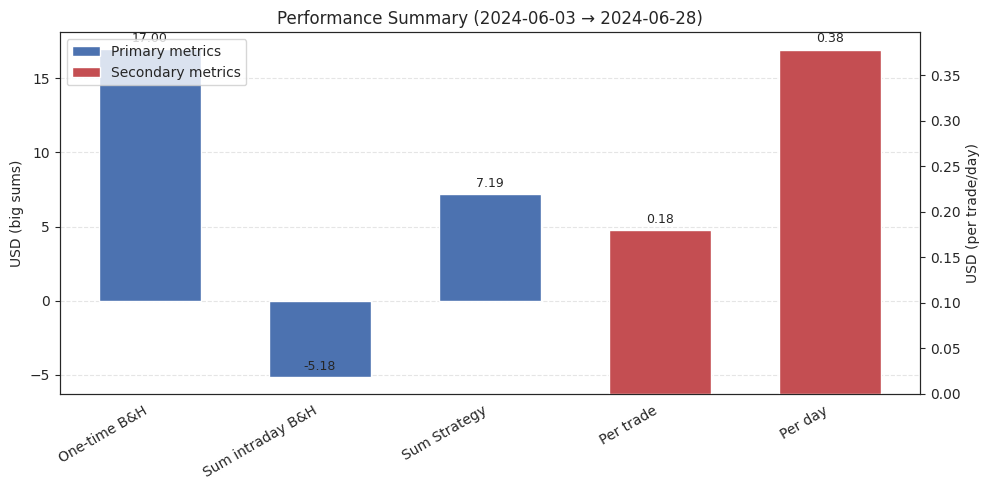


Overall Summary (2022-03-29 = 177.0727 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 19.320
Buy & Hold – each day ($): -192.076
Strategy Return ($): 6.634
Trades Count: 1575
Strategy return per trade: 0.004
Num. trading days: 809
Strategy return per trading day: 0.008


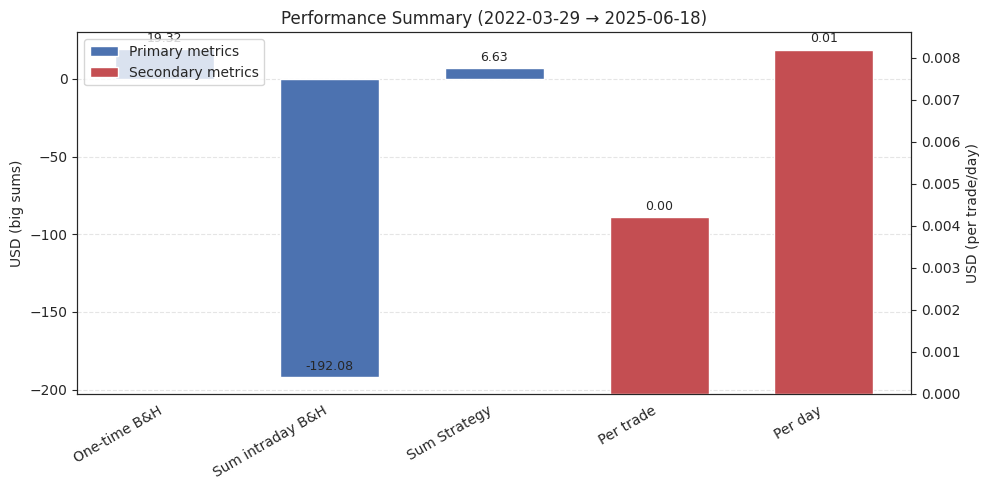

In [12]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_check

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "signal",
            col_signal2       = "pred_signal",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = pred_threshold,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_pred[df_pred.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_pred)